# Toy Monte Carlo

Nous allons commencer par voir une première methode pour générer des nombres aléatoires suivant une distribution donnée.

Il est simple de générer des nombres aléatoires suivant une distribution uniforme.

Nous allons utiliser une génération de points sur un plan de manière uniforme.

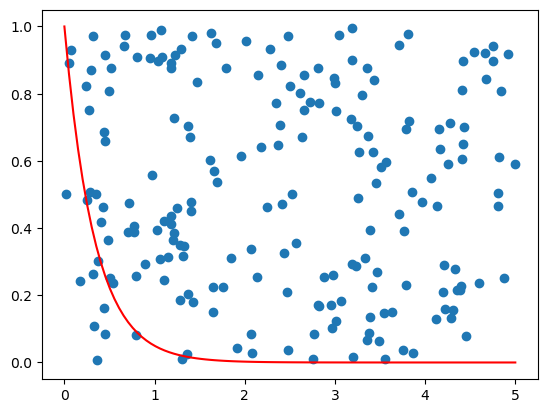

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random

def f(x, A=1, c=3):
    return A * np.exp(-c*x)

X = []
Y = []

for _ in range(0,200):
    x = random.uniform(0,5)
    y = random.uniform(0,1)
    X.append(x)
    Y.append(y)

plt.scatter(X,Y, label='Points générés')
plt.plot(np.linspace(0,5,100), f(np.linspace(0,5,100)), 'r', label='Fonction f')
plt.show()


Comme vous pouvez le voir les points générés ne suivent pas la distribution de la fonction f.

f étant une densité de probabilité, nous allons juste conserver les points qui sont sous la courbe de f.

On aura donc bien une majorité de x pour lesquels f(x) est grand et peu pour lesquels f(x) est petit.

Le problème de cette méthode est que l'efficacité n'est pas optimal, car on ne garde pas tous les points générés.

On peut cependant améliorer cette méthode en générant des points d'ordonnée y en dessous du maximum de f(x) sur l'intervalle \[0,5\]



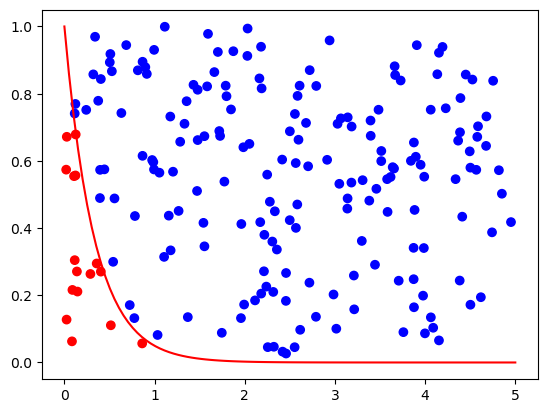

In [7]:
colors = []
X = []
Y = []
for _ in range(0,200):
    x = random.uniform(0,5)
    y = random.uniform(0,1)
    X.append(x)
    Y.append(y)
    if y < f(x):
        colors.append('r')
    else:
        colors.append('b')

plt.scatter(X,Y, c=colors, label='Points générés')
plt.plot(np.linspace(0,5,100), f(np.linspace(0,5,100)), 'r', label='Fonction f')
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
def f(x, A=1, c=3):
    return A * np.exp(-c*x)

## Methode F-1

La methode F-1 permet d'avoir une efficacité de 100% contrairement à la méthode précédente

Cette methode se met en place de la manière suivante:

Soit f: \[a,b\] -> R, une densité de probabilité

- Définir la fonction de répartition F primitive et de la densité de probabilité f
- Trouver son inverse (qui existe focément car F est bijective pour F \[a,b\] -> \[0,1\])
- Generer un y uniforme et trouver par F le x corrspondant qui sera par conséquent le nombre alèatoir suivant la distribution f

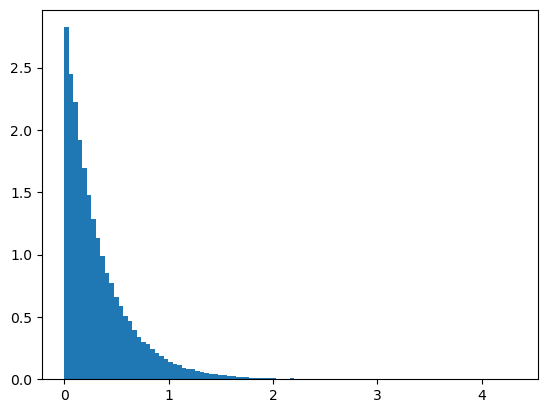

In [16]:
a,b = (0,5)
interval = (a,b)
c = 3

A = c / ( np.exp(-c*a) - np.exp(-c*b) )

def F(x, interval, A=1, c=3):
    a, b = interval
    return -A/c * np.exp(-c*x) + A/c * np.exp(-c*a)

def F_1(y, interval, A=1, c=3):
    a, b = interval
    return -1/c*np.log(-c/A * (y - A/c * np.exp(-c*a)))

X = []

for _ in range(0,100_000):
    y = random.uniform(0,1)
    X.append(F_1(y, interval, A, c))
    
plt.hist(X, bins=100, density=True)
plt.show()

## Genération de donnée pour fit un modèle

In [17]:
import random
import scipy.optimize as opt

def gen_data(n, model, sigma):
    x = np.linspace(0,10, n)
    y_th = model(x)
    sigmas = sigma(x, y_th)
    y = np.random.normal(0, sigmas) + y_th
    return x, y, sigmas

def model(x, a=2, b=0):
    return a*x+b

def sigma(x, y):
    return 0.1*y

datas = gen_data(10, model, sigma)

x, y, sigmas = datas

y_th = model(x)

# fit
def model_fit(x, a, b):
    return a*x+b

popt, pcov = opt.curve_fit(model_fit, x, y, sigma=sigmas)

print(popt)

# plot le fit


plt.errorbar(x, y, yerr=sigmas, fmt='.')
plt.plot(x, y_th, 'r')
plt.show()

K:\Programmes\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:828: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.